In [1]:
% reset
import tellurium as te
import cobra, settings, re, os, csv, itertools
from cobra.util import create_stoichiometric_matrix
import pandas as pd
import numpy as np
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
import tempfile
% matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
def FBA(model, condition, rxns_13C):
    uptake = settings.COND2BIGG[condition]
    model.reactions.get_by_id(uptake).lower_bound = rxns_13C.loc[uptake, condition]
    solution = model.optimize().fluxes
    return solution.to_frame()

rxns_13C = pd.read_csv(settings.CACHE_DIR+'/gerosa_fluxes_per_rxn.csv', index_col=0)
extended_core = cobra.io.read_sbml_model(settings.ECOLI_EXCORE_FNAME)

flux_solutions = dict()
for condition in settings.CONDITIONS:
    flux_solutions[condition] = FBA(extended_core.copy(), condition, rxns_13C)

flux_solution = flux_solutions['Acetate']
flip=[]
for rxn in extended_core.reactions:
    if not rxn.boundary:
        if float(flux_solution.loc[rxn.id]) < 0:
            flip += [rxn.id]

In [3]:
columns = [rxn.id for rxn in extended_core.reactions]
index = [met.id for met in extended_core.metabolites]
S = pd.DataFrame(create_stoichiometric_matrix(extended_core), index=index, columns=columns)

def remove_mets_rxns(S, rxns=[], mets=[]):
    """generic function for the removal of reactions and metabolites from the stoichiometric matrix"""
    if not set(rxns).issubset(set(S.columns)):
        no_match = list(set(rxns).difference(set(S.columns)))
        raise ValueError('Reactions %s do not occur in the Stoichiometrix matrix' % no_match)
    else:
        S_sub = S.drop(rxns, axis=1)
        if not (S_sub.T != 0).any().all():
            raise AssertionError('removal of reactions results in removal of metabolites')    
    return S_sub

rxns = [rxn.id for rxn in extended_core.reactions if rxn.boundary]
S_sub = remove_mets_rxns(S, rxns)

## add biomass_e as metabolite, excrete it
S_sub.loc['biomass_e'] = np.zeros(len(S_sub.columns))
S_sub.loc['biomass_e','Biomass_Ecoli_core_w_GAM'] = 1

for rxn in flip: 
    S_sub.loc[:,rxn] = S_sub.loc[:,rxn] * -1
flux_solution = abs(flux_solution)

In [4]:
class model:

    def __init__(self, S):
    
        self.S        = S
        self.P        = dict.fromkeys([x+'_0' for x in S.index])
        self.X0       = dict.fromkeys(S.index)
        self.rxns     = dict.fromkeys(S.columns)
        self.rates    = dict.fromkeys(S.columns)
        self.vmax     = dict.fromkeys(['Vmaxf_'+x for x in S.columns])
        self.exchange = [x for x in S.index if x.endswith('_e')]
        self.mapping  = dict()
        self.allo     = dict()
        
        ## add the reaction formula
        for rxn in self.rxns:
            subs, prods = [],[]
            mets = [str(self.S[rxn][i])+' '+i for i in (self.S[rxn]!=0)[self.S[rxn]!=0].index]
            for met in mets:
                c, m = met.split(' ')        
                coeff = float(c)
                new_m = str(abs(coeff))+' '+ m if (abs(coeff) != 1) else m
                if coeff < 0: 
                    subs += [new_m]
                else:
                    prods += [new_m]
            self.rxns[rxn] = ' + '.join(subs)+' -> '+' + '.join(prods)

    def add_rate(self, rxn):
        f, b, MAp, MAs = ([] for i in range(4))
        mets = [str(model.S[rxn][i])+' '+i for i in (model.S[rxn]!=0)[model.S[rxn]!=0].index]
        Vmaxf = 'Vmaxf_'+rxn; Vmaxb = 'Vmaxb_'+rxn; Keq = 'Keq_'+rxn; v = 'v_'+rxn
        E = 'E_'+rxn; kcat = 'kcat_'+rxn
        self.P[Vmaxf] = None; self.P[v] = None; # for steady-state parameterization
               
        for met in mets:
            c, m = met.split(' ')
            Km = '_'.join(['Km',rxn,m])
            self.P[Km] = None
            
            coeff = float(c)
            new_m = m + ' ^ ' + str(abs(coeff)) if (abs(coeff) != 1) else m
            if coeff < 0:
                f += [new_m + ' / ' + Km]
                MAs += [new_m]
            else:
                b += [new_m + ' / ' + Km]
                MAp += [new_m]
    
        law = 'rev_MA'
        
        if rxn == 'Biomass_Ecoli_core_w_GAM': # settings.BIOMASS_ID:
            f = []
            for met in mets:
                c, m = met.split(' ')
                Km = '_'.join(['Km',rxn,m])
                self.P[Km] = None
                coeff = float(c)
                new_m = m
                if coeff < 0:
                    f += [Km + ' / ' + new_m]
                rate = '%s / ( 1 + %s )' % (Vmaxf, ' + '.join(f))
                vmax = '%s * ( 1 + %s )' % (v, ' + '.join(f))
        
        # irreversible mass action
        elif law == 'irrev_MA': 
            rate = '%s * %s' % (Vmaxf, ' * '.join(MAs))
            vmax = '%s / %s' % (v, ' * '.join(MAs))

        # irreversible Michaelis-Menten
        elif law == 'irrev_MM':
            num  = ' * '.join(f)
            den  = '( 1 + %s )'       % (' + '.join(f))
            rate = '( %s * %s / %s )' % (Vmaxf, num, den)
            vmax = '( %s * %s / %s )' % (v, den, num)

        # reversible mass action
        elif law == 'rev_MA': 
            rev = 'rev_'+rxn
            self.P[rev] = None
            v_f   = '%s * ( 1 + %s )'   % (v, rev)
            v_b   = '%s * %s'           % (v, rev)
            vmax  = '%s / ( %s )'       % (v_f, ' * '.join(MAs))
            vmaxb = '%s / ( %s )'       % (v_b, ' * '.join(MAp))
            rate  = '%s * %s - %s * %s' % (Vmaxf, ' * '.join(MAs), Vmaxb, ' * '.join(MAp))
            self.vmax[Vmaxb] = vmaxb
            self.P[Vmaxb] = None
              
        # reversible michaelis-menten with haldane substitution    
        elif law == 'Haldane': 
            self.P[Keq] = None;
            rev  = '( 1 - ( %s / %s ) / %s )'  % (' * '.join(MAp), ' * '.join(MAs), Keq)
            num  = ' * '.join(f)
            den  = '( 1 + %s + %s )'           % (' + '.join(f), ' + '.join(b))
            rate = '( %s * %s * %s / %s )'     % (Vmaxf, rev, num, den)
            vmax = '( %s / ( %s * %s / %s ) )' % (v, rev, num, den)
        
        self.rates[rxn] = rate
        self.vmax[Vmaxf] = vmax
    
    def allostery(self):
        for rxn in self.S.columns:
            allo_str = ''
            for met in self.S.index:
                a = 'a_'+rxn+'_'+met
                self.P[a] = None
                allo_str += ' * ( '+met+' / '+met+'_0 ) ** '+a
            self.allo['allo_'+rxn] = allo_str # place holder parameter to split regulation from the rate law
            self.P['allo_'+rxn] = None

    def map_names(self):
        for i,met in enumerate(self.X0):
            self.mapping[met] = 'S'+str(i)
        for i,par in enumerate(self.P):
            self.mapping[par] = 'P'+str(i)
        for i,rxn in enumerate(self.rxns): 
            self.mapping[rxn] = 'R'+str(i)
        self.mapping.update({v: k for k, v in self.mapping.items()})
            
    def parameterize(self, flux_solution): 
        
        def get_truncnorm(mean=0, sd=1, lb=0, ub=10):
            return truncnorm((lb - mean) / sd, (ub - mean) / sd, loc=mean, scale=sd)
        
        for k,v in self.P.items():
            if k[2:] in flux_solution.index: ## 'v_'+rxn
                self.P[k] = str(float(flux_solution.loc[k[2:]]))
            elif k.startswith('rev_'): # reversibility for rev_MA
                self.P[k] = str(np.random.uniform(0.2, 0.8))
            else:
                self.P[k] = str(get_truncnorm(mean=1, sd=1, lb=0.1, ub=10).rvs())
                
        for k,v in self.X0.items():
            val = str(get_truncnorm(mean=1, sd=1, lb=0.1, ub=3).rvs())
            self.X0[k] = val
            self.P[k+'_0'] = val
            
        for k,v in self.vmax.items(): # rewrite in terms of initial conditions
            self.vmax[k] = ' '.join([x+'_0' if x in self.X0 else x for x in v.split(' ')]) 
                
    def to_antimony(self):
    
        def convert_string(string):
            return ' '.join([self.mapping[x] if x in self.mapping else x for x in string.split(' ')])
        
        def calculate_vmax(vmax):
            return str(eval(' '.join([self.P[x] if x in self.P else x for x in vmax.split(' ')]).replace('^','**')))
        
        antimony_model = ''''''
        antimony_model += '// model *coli_core()'

        antimony_model += '\n\n// Reactions:'       
        for rxn, formula in self.rxns.items():
            formula = ' '.join(['$ '+x if x in self.exchange else x for x in formula.split(' ')])
            antimony_model += '\n'+self.mapping[rxn]+': '+convert_string(formula)+'; '+convert_string(self.rates[rxn]) + ';'
        
        antimony_model += '\n\n// Initial conditions:\n'
        for met, value in self.X0.items():
            antimony_model += ''+self.mapping[met]+' = '+value+'; '

        antimony_model += '\n\n// Parameters:\n'
        for par, value in self.P.items():
            antimony_model += ''+self.mapping[par]+' = '+value+'; '

        antimony_model += '\n\n// Derived parameters:'
        for rxn, vmax in self.vmax.items():
            vmax = calculate_vmax(vmax)
            antimony_model += '\n '+self.mapping[rxn]+' = '+vmax+'; '

        return antimony_model

model = model(S_sub)

for rxn in model.rates:
    model.add_rate(rxn)
    
model.map_names()

model.parameterize(flux_solution)

antimony_model = model.to_antimony()
print(antimony_model)


// model *coli_core()

// Reactions:
R0: S7 + S20 + S49 -> S9 + S42 + S50; P87 * S7 * S20 * S49 - P96 * S9 * S42 * S50;
R1: $ S8 -> S7; P97 * S8 - P102 * S7;
R2: S5 + S16 -> S11 + S12; P103 * S5 * S16 - P110 * S11 * S12;
R3: S17 -> S10 + S40; P111 * S17 - P117 * S10 * S40;
R4: S10 + S40 -> S44; P118 * S10 * S40 - P124 * S44;
R5: $ S6 + $ S43 -> S5 + S42; P125 * S6 * S43 - P132 * S5 * S42;
R6: S15 + S16 -> 2.0 S12; P133 * S15 * S16 - P139 * S12 ^ 2.0;
R7: S13 + S20 + S49 -> S18 + S50 + S70; P140 * S13 * S20 * S49 - P149 * S18 * S50 * S70;
R8: $ S14 + $ S43 -> S13 + S42; P150 * S14 * S43 - P157 * S13 * S42;
R9: S23 + S49 -> S7 + S42 + S50; P158 * S23 * S49 - P166 * S7 * S42 * S50;
R10: S16 + S40 -> S12 + S42 + S59; P167 * S16 * S40 - P175 * S12 * S42 * S59;
R11: S12 + 4.0 $ S43 + S59 -> S16 + S40 + 3.0 S42; P176 * S12 * S43 ^ 4.0 * S59 - P185 * S16 * S40 * S42 ^ 3.0;
R12: 1.496 S2 + 3.7478 S9 + 59.81 S16 + 0.361 S22 + 0.0709 S25 + 0.129 S32 + 0.205 S33 + 0.2557 S35 + 4.9414 S37 + 59.81 S

In [5]:
def add_event(antimony_model, time='', event=''):
    antimony_model += '\nat (time > '+time+'): '+event+';' 
    return antimony_model

def perturb(antimony_model):
    antimony_model += '\n\n //Events: '
    antimony_model = add_event(antimony_model, time='10' , event='S0 = S0 * 0.9')
    antimony_model = add_event(antimony_model, time='20', event='S0 = %s' % model.P[model.mapping['S0']+'_0'])
    return antimony_model

antimony_model = perturb(antimony_model)

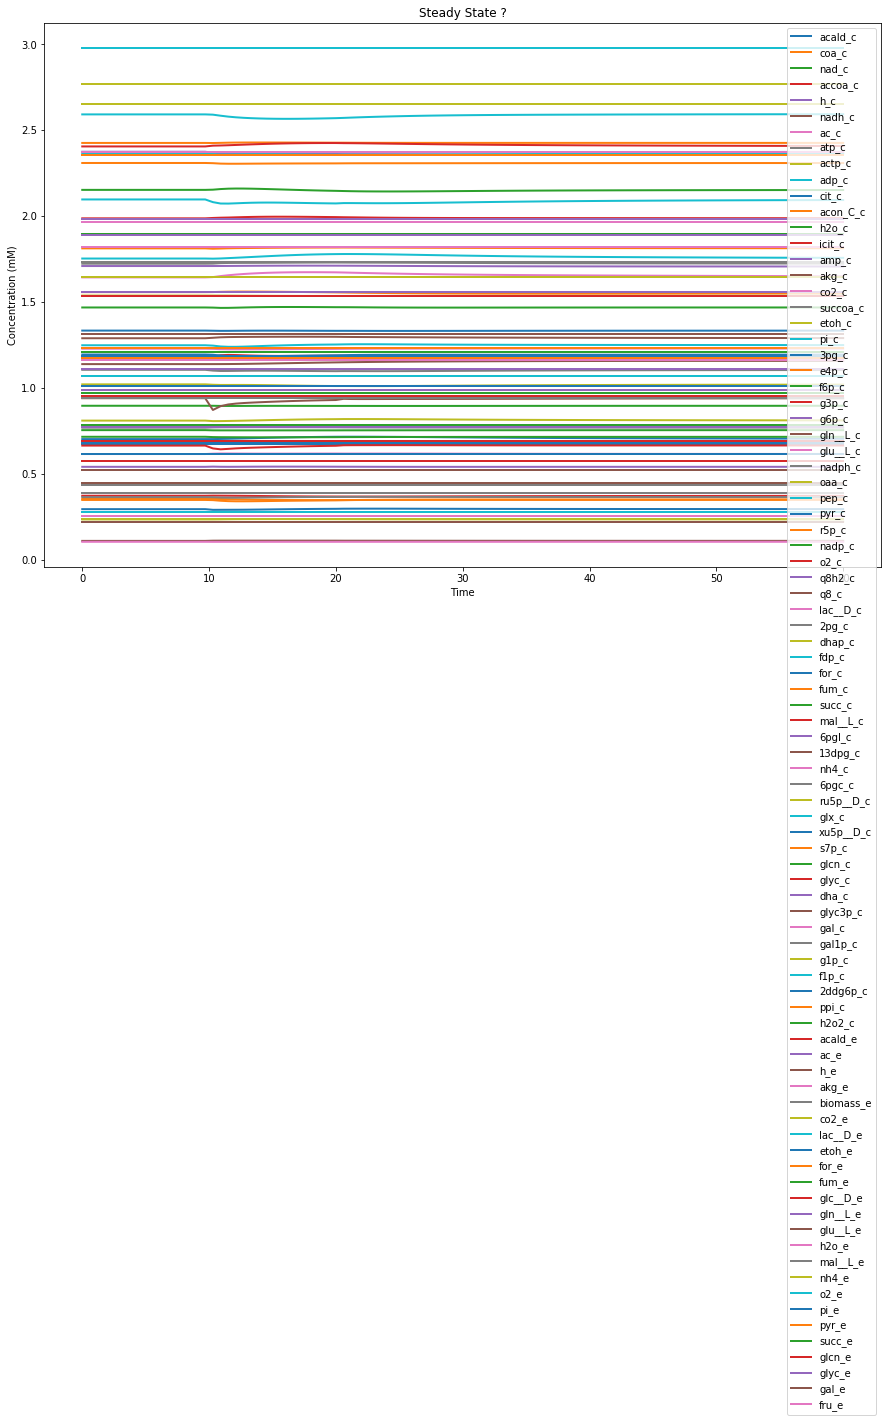

In [6]:
r = te.loada(antimony_model) 
# r.timeCourseSelections= ['time'] + ['R'+str(i) for i in range(0,len(model.rates))]# r.getFloatingSpeciesIds() + r.getBoundarySpeciesIds()
r.timeCourseSelections= ['time'] + r.getFloatingSpeciesIds() + r.getBoundarySpeciesIds()
sim_data = r.simulate(0,60,100)
fig = plt.figure(figsize=(15,10))
new = [model.mapping[x] for x in r.getFloatingSpeciesIds()+ r.getBoundarySpeciesIds()]
te.plotArray(sim_data, ylabel='Concentration (mM)', xlabel='Time',
           title='Steady State ?', labels=new)
